In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import get_peft_model_state_dict

/home/jayo/miniconda3/envs/llm_utils/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load LoRA adapters

In [2]:
bom_model_id = "royal42/final_bom_lora_adapter"
arxiv_model_id = "royal42/final_arxiv_lora_adapter"

In [3]:
model_id = "HuggingFaceTB/SmolLM2-360M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")
bom_model = AutoModelForCausalLM.from_pretrained(bom_model_id, torch_dtype=torch.bfloat16, device_map="auto")
arxiv_model = AutoModelForCausalLM.from_pretrained(arxiv_model_id, torch_dtype=torch.bfloat16, device_map="auto")

`torch_dtype` is deprecated! Use `dtype` instead!


In [4]:
bom_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 960)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=960, out_features=960, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=960, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=960, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=960, out_features=320, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropo

In [5]:
lora_bom = get_peft_model_state_dict(bom_model)
lora_arxiv = get_peft_model_state_dict(arxiv_model)

In [6]:
bom_model.model.layers[0].self_attn.q_proj.lora_A["default"].weight

Parameter containing:
tensor([[-0.0058, -0.0147,  0.0159,  ...,  0.0007,  0.0110,  0.0197],
        [ 0.0278,  0.0112,  0.0303,  ...,  0.0286, -0.0051, -0.0170],
        [-0.0276,  0.0137,  0.0231,  ...,  0.0275, -0.0142, -0.0109],
        ...,
        [-0.0076,  0.0232,  0.0311,  ..., -0.0038, -0.0023,  0.0027],
        [-0.0110, -0.0056, -0.0254,  ...,  0.0093,  0.0229, -0.0043],
        [-0.0069, -0.0347,  0.0110,  ...,  0.0265,  0.0129, -0.0327]],
       device='cuda:0', dtype=torch.bfloat16)

In [7]:
print(lora_bom.keys())

dict_keys(['model.layers.0.self_attn.q_proj.lora_A.weight', 'model.layers.0.self_attn.q_proj.lora_B.weight', 'model.layers.0.self_attn.k_proj.lora_A.weight', 'model.layers.0.self_attn.k_proj.lora_B.weight', 'model.layers.0.self_attn.v_proj.lora_A.weight', 'model.layers.0.self_attn.v_proj.lora_B.weight', 'model.layers.0.self_attn.o_proj.lora_A.weight', 'model.layers.0.self_attn.o_proj.lora_B.weight', 'model.layers.0.mlp.gate_proj.lora_A.weight', 'model.layers.0.mlp.gate_proj.lora_B.weight', 'model.layers.0.mlp.up_proj.lora_A.weight', 'model.layers.0.mlp.up_proj.lora_B.weight', 'model.layers.0.mlp.down_proj.lora_A.weight', 'model.layers.0.mlp.down_proj.lora_B.weight', 'model.layers.1.self_attn.q_proj.lora_A.weight', 'model.layers.1.self_attn.q_proj.lora_B.weight', 'model.layers.1.self_attn.k_proj.lora_A.weight', 'model.layers.1.self_attn.k_proj.lora_B.weight', 'model.layers.1.self_attn.v_proj.lora_A.weight', 'model.layers.1.self_attn.v_proj.lora_B.weight', 'model.layers.1.self_attn.o_pro

In [8]:
from peft.tuners.lora import Linear as LoraLinear

In [9]:
alpha = 128
r = 64

In [10]:
similarities = []
for name, module1 in bom_model.named_modules():
    if isinstance(module1, LoraLinear):
        module2 = dict(arxiv_model.named_modules()).get(name, None)

        print(f"Comparing module: {name}")

        w_a_bom = module1.lora_A["default"].weight
        w_b_bom = module1.lora_B["default"].weight

        w_a_arxiv = module2.lora_A["default"].weight
        w_b_arxiv = module2.lora_B["default"].weight

        delta_w_bom = (w_b_bom @ w_a_bom) * (alpha / r)
        delta_w_arxiv = (w_b_arxiv @ w_a_arxiv) * (alpha / r)

        # flatten to vectors
        delta_w_bom = delta_w_bom.flatten().float()
        delta_w_arxiv = delta_w_arxiv.flatten().float()

        sim = torch.nn.functional.cosine_similarity(delta_w_bom, delta_w_arxiv, dim=0)
        similarities.append((name, sim.item()))
        print(f"Cosine similarity for delta W in module {name}: {sim.item()}")

Comparing module: model.layers.0.self_attn.q_proj
Cosine similarity for delta W in module model.layers.0.self_attn.q_proj: 0.0009028860367834568
Comparing module: model.layers.0.self_attn.k_proj
Cosine similarity for delta W in module model.layers.0.self_attn.k_proj: 0.0014220098964869976
Comparing module: model.layers.0.self_attn.v_proj
Cosine similarity for delta W in module model.layers.0.self_attn.v_proj: 0.0018608355894684792
Comparing module: model.layers.0.self_attn.o_proj
Cosine similarity for delta W in module model.layers.0.self_attn.o_proj: 0.0034431617241352797
Comparing module: model.layers.0.mlp.gate_proj
Cosine similarity for delta W in module model.layers.0.mlp.gate_proj: 0.0032172948122024536
Comparing module: model.layers.0.mlp.up_proj
Cosine similarity for delta W in module model.layers.0.mlp.up_proj: 0.004559109918773174
Comparing module: model.layers.0.mlp.down_proj
Cosine similarity for delta W in module model.layers.0.mlp.down_proj: 0.0011905813589692116
Comparin

These weight vectors appear to be fairly orthogonal (near 0) between models, indicating that there is not much interference when comparing the weights of the network.

In [11]:
print('average similarity:', sum(sim for _, sim in similarities) / len(similarities))

average similarity: 0.033951377568623035


Check vocabularly projection
1. for each lora adapter, get the weights for the final layer
2. apply softmax/normalize
3. look at the top tokens. Sort by norm and see what's been boosted for each model.

In [12]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 960)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=960, out_features=960, bias=False)
          (k_proj): Linear(in_features=960, out_features=320, bias=False)
          (v_proj): Linear(in_features=960, out_features=320, bias=False)
          (o_proj): Linear(in_features=960, out_features=960, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=960, out_features=2560, bias=False)
          (up_proj): Linear(in_features=960, out_features=2560, bias=False)
          (down_proj): Linear(in_features=2560, out_features=960, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((960,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((960,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((960,), eps=1e-05)
    (rotary_emb): Lla

In [13]:
bom_b = bom_model.model.layers[-1].mlp.down_proj.lora_B["default"].weight
print(bom_b.shape)
lm_head = model.lm_head.weight
print(lm_head.shape)

torch.Size([960, 64])
torch.Size([49152, 960])


In [14]:
vocab_projection = lm_head @ bom_b

In [15]:
vocab_size, rank = vocab_projection.shape
print(vocab_size, rank)

49152 64


In [16]:
for r in range(rank):
    rank_logits = vocab_projection[:, r]
    top_values, top_indices = torch.topk(rank_logits, 10)
    print(f"Rank {r}:")
    for value, index in zip(top_values, top_indices):
        token = tokenizer.decode(index.item())
        print(f"  Token: {token}, \n Value: {value.item()}")

Rank 0:
  Token: :`~, 
 Value: 0.060791015625
  Token:  transist, 
 Value: 0.059814453125
  Token: isational, 
 Value: 0.057861328125
  Token:  constell, 
 Value: 0.056396484375
  Token:  irres, 
 Value: 0.055908203125
  Token:  interspers, 
 Value: 0.055419921875
  Token:  behav, 
 Value: 0.053955078125
  Token:  contrad, 
 Value: 0.053955078125
  Token:  stim, 
 Value: 0.053466796875
  Token:  deterior, 
 Value: 0.05322265625
Rank 1:
  Token: <|endoftext|>, 
 Value: 0.2109375
  Token: )))), 
 Value: 0.059326171875
  Token: owered, 
 Value: 0.05615234375
  Token: Leave, 
 Value: 0.051513671875
  Token: ))), 
 Value: 0.04638671875
  Token: \_, 
 Value: 0.04296875
  Token: ]]:, 
 Value: 0.0419921875
  Token: .…, 
 Value: 0.040283203125
  Token:  concludes, 
 Value: 0.0400390625
  Token: '))), 
 Value: 0.0400390625
Rank 2:
  Token: <|endoftext|>, 
 Value: 0.1865234375
  Token: Leave, 
 Value: 0.0458984375
  Token: owered, 
 Value: 0.04052734375
  Token: )))), 
 Value: 0.038818359375
  To

In [17]:
arxiv_b = arxiv_model.model.layers[-1].mlp.down_proj.lora_B["default"].weight
lm_head = model.lm_head.weight

vocab_projection = lm_head @ arxiv_b

vocab_size, rank = vocab_projection.shape

for r in range(rank):
    rank_logits = vocab_projection[:, r]
    top_values, top_indices = torch.topk(rank_logits, 10)
    print(f"Rank {r}:")
    for value, index in zip(top_values, top_indices):
        token = tokenizer.decode(index.item())
        print(f"  Token: {token}, \n Value: {value.item()}")

Rank 0:
  Token: ?](, 
 Value: 0.05029296875
  Token:  retros, 
 Value: 0.0478515625
  Token:  behav, 
 Value: 0.046142578125
  Token:  favourite, 
 Value: 0.045654296875
  Token:  manoe, 
 Value: 0.044921875
  Token:  colourful, 
 Value: 0.04345703125
  Token:  behavioural, 
 Value: 0.04345703125
  Token: stuffs, 
 Value: 0.04296875
  Token:  behaviour, 
 Value: 0.041748046875
  Token:  blame, 
 Value: 0.041259765625
Rank 1:
  Token:  retros, 
 Value: 0.06640625
  Token:  behav, 
 Value: 0.0634765625
  Token: stuffs, 
 Value: 0.06005859375
  Token:  constell, 
 Value: 0.059814453125
  Token:  ingred, 
 Value: 0.05908203125
  Token:  ardu, 
 Value: 0.05810546875
  Token:  authent, 
 Value: 0.057861328125
  Token:  chromos, 
 Value: 0.05712890625
  Token:  transist, 
 Value: 0.05712890625
  Token:  advoc, 
 Value: 0.056396484375
Rank 2:
  Token: <|endoftext|>, 
 Value: 0.2578125
  Token: Leave, 
 Value: 0.0673828125
  Token: .…, 
 Value: 0.06103515625
  Token: owered, 
 Value: 0.0590820

Check cos sim between ranks

In [22]:
# normalize
vocab_projection = vocab_projection / torch.norm(vocab_projection, dim=0, keepdim=True)

In [23]:
sim_matrix = torch.matmul(vocab_projection.T, vocab_projection)

In [24]:
sim_matrix_np = sim_matrix.detach().float().cpu().numpy()

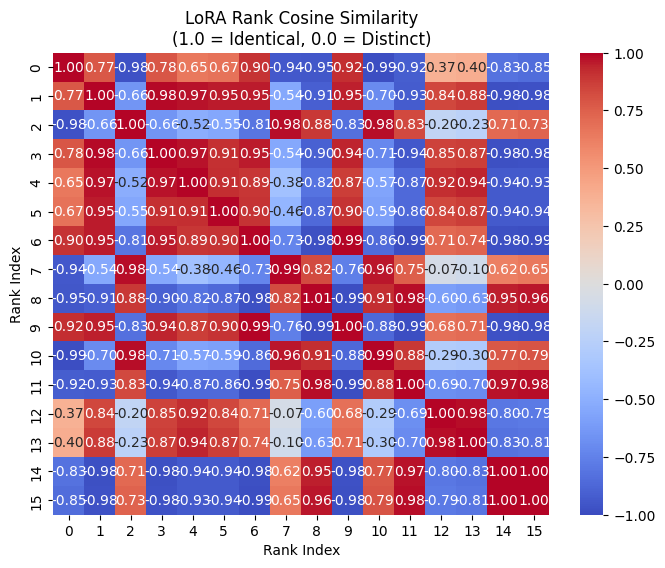

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix_np[:16,:16], annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt=".2f")
plt.title("LoRA Rank Cosine Similarity\n(1.0 = Identical, 0.0 = Distinct)")
plt.xlabel("Rank Index")
plt.ylabel("Rank Index")
plt.show()